<a href="https://colab.research.google.com/github/Frads01/NoiseRemover/blob/main/NoiseRemover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Noise Remover


Import librerie:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

base_dir = Path("/content/drive/MyDrive/dataset")
(base_dir / "Weights").mkdir(parents=True, exist_ok=True)
(base_dir / "Samples").mkdir(parents=True, exist_ok=True)


Mounted at /content/drive


In [2]:
import torch
import torchaudio
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import IPython.display as ipd
from torch.utils.data import Dataset, DataLoader
import gc
from tqdm import tqdm, tqdm_notebook

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# determinismo CUDA GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


Indicazione Path per i dati di input e target:

In [3]:
TRAIN_INPUT_DIR = base_dir / 'train' / 'input'
TRAIN_TARGET_DIR = base_dir / 'train'/ 'target'

TEST_NOISY_DIR = base_dir / 'test' / 'input'
TEST_CLEAN_DIR = base_dir / 'test'/ 'target'

Parametri per la trasformazione STFT:

In [4]:
SAMPLE_RATE = 44100
n_fft = 2048 # grandezza della finestra (risoluzione in frequenza) - nel paper è 3072, ottima per il parlato
hop_length = 512 # salto tra una finestra e l’altra (risoluzione temporale) - nel paper è 768

# Dichiarazioni del Dataset e del Dataloader

In [5]:
class Noise2NoiseDataset(Dataset):
    """
    Dataset per training Noise2Noise su audio.
    Ogni esempio ha due versioni rumorose dello stesso contenuto.
    """
    def __init__(self, noisy_file_set_A, noisy_file_set_B, n_fft=1024, hop_length=256):
        super().__init__()
        self.noisy_A = sorted(noisy_file_set_A)
        self.noisy_B = sorted(noisy_file_set_B)

        assert len(self.noisy_A) == len(self.noisy_B), "Le due liste devono avere la stessa lunghezza."

        self.n_fft = n_fft
        self.hop_length = hop_length
        self.max_len = 165000  # puoi regolarla

    def __len__(self):
        return len(self.noisy_A)

    def load_sample(self, file):
        waveform, sample_rate = torchaudio.load(file)
        signal_length = waveform.shape[1]
        return waveform

    def _prepare_sample(self, waveform):
        """Pad o tronca a self.max_len campioni, da sinistra o destra."""
        if waveform.shape[0] > 1:
            waveform = waveform[:1, :]  # prendi solo 1 canale

        current_len = waveform.shape[1]

        if current_len >= self.max_len:
            waveform = waveform[:, :self.max_len]
        else:
            pad_len = self.max_len - current_len
            waveform = torch.nn.functional.pad(waveform, (0, pad_len), mode='constant', value=0.0)

        return waveform

    def __getitem__(self, index):
      # carica audio
        x1 = self.load_sample(self.noisy_A[index])
        x2 = self.load_sample(self.noisy_B[index])

        # padding/troncamento
        x1 = self._prepare_sample(x1)
        x2 = self._prepare_sample(x2)

        # STFT
        x1_stft = torch.stft(x1, n_fft=self.n_fft, hop_length=self.hop_length, normalized=True, return_complex=True)
        x1_stft = torch.view_as_real(x1_stft)  # da [B, F, T] complesso a [B, F, T, 2]

        x2_stft = torch.stft(x2, n_fft=self.n_fft, hop_length=self.hop_length, normalized=True, return_complex=True)
        x2_stft = torch.view_as_real(x2_stft)

        return x1_stft, x2_stft

files_noise_input = sorted(list(TRAIN_INPUT_DIR.rglob("*.wav")))
files_noise_target = sorted(list(TRAIN_TARGET_DIR.rglob("*.wav")))
test_noisy_files = sorted(list(TEST_NOISY_DIR.rglob('*.wav')))
test_clean_files = sorted(list(TEST_CLEAN_DIR.rglob('*.wav')))

print("No. of Training files:",len(files_noise_input))
print("No. of Test files:",len(test_noisy_files))

noise2noise_dataset = Noise2NoiseDataset(files_noise_input, files_noise_target, n_fft, hop_length)
test_dataset = Noise2NoiseDataset(test_noisy_files, test_clean_files, n_fft, hop_length)

train_loader = DataLoader(noise2noise_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# For testing purpose
test_loader_single_unshuffled = DataLoader(test_dataset, batch_size=1, shuffle=False)

No. of Training files: 620
No. of Test files: 107


# Metriche

In [6]:
class AudioMetricsGeneral:
    def __init__(self, target_audio, input_audio, fs):
        if len(target_audio) != len(input_audio):
            raise Exception("Signal lengths don't match!")

        self.min_cutoff = 0.01
        self.clip_values = (-self.min_cutoff, self.min_cutoff)

        clean_audio = np.zeros(shape=target_audio.shape)
        processed_audio = np.zeros(shape=input_audio.shape)

        for index, data in np.ndenumerate(target_audio):
            if data == 0:
                clean_audio[index] = 0.01
            else:
                clean_audio[index] = data

        for index, data in np.ndenumerate(input_audio):
            if data == 0:
                processed_audio[index] = 0.01
            else:
                processed_audio[index] = data

        self.SNR = snr(target_audio, input_audio)
        self.SSNR = SNRseg(target_audio, input_audio, fs)

    def display(self):
        fstring = "{} : {:.3f}"
        metric_names = ["SNR", "SSNR"]
        for name in metric_names:
            metric_value = eval("self." + name)
            print(fstring.format(name, metric_value))


# Formula Reference: http://www.irisa.fr/armor/lesmembres/Mohamed/Thesis/node94.html

def snr(reference, test):
    numerator = np.sum(np.square(reference))
    denominator = np.sum(np.square(reference - test))

    eps = np.finfo(np.float64).eps
    snr_value = 10 * np.log10((numerator + eps) / (denominator + eps))

    # Clamp per evitare -inf, inf, NaN
    if np.isnan(snr_value) or np.isinf(snr_value):
        return -100.0  # valore segnaposto basso
    return snr_value



# Reference : https://github.com/schmiph2/pysepm

def SNRseg(clean_signal, processed_signal, fs, frameLen=0.1, overlap=0.5):
    eps = np.finfo(np.float64).eps

    winlength = round(frameLen * fs)
    skiprate = int(np.floor((1 - overlap) * winlength))

    MIN_SNR = -10
    MAX_SNR = 35

    hannWin = 0.5 * (1 - np.cos(2 * np.pi * np.arange(1, winlength + 1) / (winlength + 1)))

    clean_framed = extract_overlapped_windows(clean_signal, winlength, winlength - skiprate, hannWin)
    processed_framed = extract_overlapped_windows(processed_signal, winlength, winlength - skiprate, hannWin)

    signal_energy = np.sum(np.square(clean_framed), axis=-1)
    noise_energy = np.sum(np.square(clean_framed - processed_framed), axis=-1)

    # Aggiungi eps solo al denominatore per evitare inf/NaN
    segmental_snr = 10 * np.log10((signal_energy + eps) / (noise_energy + eps))

    # Clamp dei valori
    segmental_snr = np.clip(segmental_snr, MIN_SNR, MAX_SNR)

    return np.mean(segmental_snr[:-1])


def extract_overlapped_windows(x,nperseg,noverlap,window=None):
    step = nperseg - noverlap
    shape = x.shape[:-1]+((x.shape[-1]-noverlap)//step, nperseg)
    strides = x.strides[:-1]+(step*x.strides[-1], x.strides[-1])
    result = np.lib.stride_tricks.as_strided(x, shape=shape,
                                             strides=strides)
    if window is not None:
        result = window * result
    return result

# Definizione dei diversi layer

Layer convoluzionale per segnali complessi:

In [7]:
class ComplexConv2d(nn.Module):  # convoluzione 2D su numeri complessi
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
      super().__init__()

      self.in_channels = in_channels
      self.out_channels = out_channels
      self.kernel_size = kernel_size
      self.padding = padding
      self.stride = stride

      # crea una convoluzione per la parte reale:
      self.real_conv = nn.Conv2d(in_channels=self.in_channels,
                                 out_channels=self.out_channels,
                                 kernel_size=self.kernel_size,
                                 padding=self.padding,
                                 stride=self.stride)

      # crea un’altra convoluzione per la parte immaginaria.
      # Nota: è separata, quindi ha i suoi pesi e bias distinti.
      self.im_conv = nn.Conv2d(in_channels=self.in_channels,
                               out_channels=self.out_channels,
                               kernel_size=self.kernel_size,
                               padding=self.padding,
                               stride=self.stride)

      # Glorot initialization.
      nn.init.xavier_uniform_(self.real_conv.weight)
      nn.init.xavier_uniform_(self.im_conv.weight)

  def forward(self, x):  # x: è un tensore che contiene, sull’ultima dimensione, la parte reale e immaginaria
        x_real = x[..., 0]
        x_im = x[..., 1]

        # calcolo convoluzione complessa
        c_real = self.real_conv(x_real) - self.im_conv(x_im)
        c_im = self.im_conv(x_real) + self.real_conv(x_im)

        # combino le due parti (reale e immaginaria) di nuovo insieme, lungo l’ultima dimensione (dim = -1), per restituire un tensore complesso.
        output = torch.stack([c_real, c_im], dim=-1)
        return output

Layer per deconvoluzione di segnali complessi:

In [8]:
class ComplexConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding=0, padding=0):
        super().__init__()

        self.in_channels = in_channels

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.output_padding = output_padding
        self.padding = padding
        self.stride = stride

        self.real_convt = nn.ConvTranspose2d(in_channels=self.in_channels,
                                            out_channels=self.out_channels,
                                            kernel_size=self.kernel_size,
                                            output_padding=self.output_padding,
                                            padding=self.padding,
                                            stride=self.stride)

        self.im_convt = nn.ConvTranspose2d(in_channels=self.in_channels,
                                            out_channels=self.out_channels,
                                            kernel_size=self.kernel_size,
                                            output_padding=self.output_padding,
                                            padding=self.padding,
                                            stride=self.stride)


        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.im_convt.weight)


    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]

        ct_real = self.real_convt(x_real) - self.im_convt(x_im)
        ct_im = self.im_convt(x_real) + self.real_convt(x_im)

        output = torch.stack([ct_real, ct_im], dim=-1)
        return output

Layer per la batch normalization di segnali complessi:

In [9]:
class ComplexBatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()

        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats

        self.real_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.im_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                    affine=self.affine, track_running_stats=self.track_running_stats)

    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]

        n_real = self.real_b(x_real)
        n_im = self.im_b(x_im)

        output = torch.stack([n_real, n_im], dim=-1)
        return output

Layer Encoder:

In [10]:
class Encoder(nn.Module):
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45, padding=(0,0)):
        super().__init__()

        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding

        self.cconv = ComplexConv2d(in_channels=self.in_channels, out_channels=self.out_channels,
                             kernel_size=self.filter_size, stride=self.stride_size, padding=self.padding)

        self.cbn = ComplexBatchNorm2d(num_features=self.out_channels)

        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):

        conved = self.cconv(x)
        normed = self.cbn(conved)
        acted = self.leaky_relu(normed)

        return acted

Layer Decoder:

In [11]:
class Decoder(nn.Module):
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45,
                 output_padding=(0,0), padding=(0,0), last_layer=False):
        super().__init__()

        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_padding = output_padding
        self.padding = padding

        self.last_layer = last_layer

        self.cconvt = ComplexConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels,
                             kernel_size=self.filter_size, stride=self.stride_size, output_padding=self.output_padding, padding=self.padding)

        self.cbn = ComplexBatchNorm2d(num_features=self.out_channels)

        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):

        conved = self.cconvt(x)

        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag

        return output

# Funzione di Loss

In [12]:
def wsdr_fn(x_, y_pred_, y_true_, eps=1e-8):  # Weighted SDR loss
    # Rimuove dimensione batch channel [B, 1, F, T, 2] → [B, F, T, 2]
    y_true_ = torch.squeeze(y_true_, 1)
    x_ = torch.squeeze(x_, 1)
    y_pred_ = torch.squeeze(y_pred_, 1)

    # Converti a tensore complesso se ha dimensione 2 nell'ultimo asse e non è già complesso
    if y_true_.shape[-1] == 2 and not y_true_.is_complex():
        y_true_ = torch.view_as_complex(y_true_)
    if x_.shape[-1] == 2 and not x_.is_complex():
        x_ = torch.view_as_complex(x_)

    # Istft solo su y_true_ e x_ (spettrogrammi)
    y_true = torch.istft(y_true_, n_fft=n_fft, hop_length=hop_length, normalized=True)
    x = torch.istft(x_, n_fft=n_fft, hop_length=hop_length, normalized=True)

    # Per y_pred_ controlla se è complesso e se sì fai istft, altrimenti assumilo già come waveform
    if y_pred_.shape[-1] == 2 and not y_pred_.is_complex():
        y_pred_ = torch.view_as_complex(y_pred_)
        y_pred = torch.istft(y_pred_, n_fft=n_fft, hop_length=hop_length, normalized=True)
    else:
        y_pred = y_pred_

    def sdr_fn(true, pred, eps=1e-8):
        num = torch.sum(true * pred, dim=1)
        den = torch.norm(true, p=2, dim=1) * torch.norm(pred, p=2, dim=1)
        return -(num / (den + eps))

    # true and estimated noise
    z_true = x - y_true
    z_pred = x - y_pred

    a = torch.sum(y_true**2, dim=1) / (torch.sum(y_true**2, dim=1) + torch.sum(z_true**2, dim=1) + eps)
    wSDR = a * sdr_fn(y_true, y_pred) + (1 - a) * sdr_fn(z_true, z_pred)
    return torch.mean(wSDR)


def getMetricsonLoader(loader, net, use_net=True):
    net.eval()
    metric_names = ["SNR", "SSNR"]
    overall_metrics = [[] for _ in range(len(metric_names))]

    # itera sui batch del DataLoader
    for i, data in enumerate(loader):
        noisy = data[0]
        clean = data[1]

        # se vogliamo usare il modello per produrre il segnale pulito stimato
        if use_net:
            x_est = net(noisy.to(device), is_istft=True)
            x_est_np = x_est.view(-1).detach().cpu().numpy()
        else:
            noisy = torch.squeeze(noisy, 1)  # [B, F, T, 2]
            if noisy.shape[-1] == 2 and not noisy.is_complex():
                noisy = torch.view_as_complex(noisy)
            x_est = torch.istft(noisy, n_fft=n_fft, hop_length=hop_length, normalized=True)
            x_est_np = x_est.view(-1).detach().cpu().numpy()

        clean = torch.squeeze(clean, 1)  # [B, F, T, 2]
        if clean.shape[-1] == 2 and not clean.is_complex():
            clean = torch.view_as_complex(clean)
        x_clean = torch.istft(clean, n_fft=n_fft, hop_length=hop_length, normalized=True)
        x_clean_np = x_clean.view(-1).detach().cpu().numpy()
        # assumiamo che lavori a 48 kHz.
        metrics = AudioMetricsGeneral(x_clean_np, x_est_np, 48000)

        overall_metrics[0].append(metrics.SNR)
        overall_metrics[1].append(metrics.SSNR)

    print("\nSample metrics computed")
    results = {}
    for i in range(len(metric_names)):
        temp = {
            "Mean": np.mean(overall_metrics[i]),
            "STD": np.std(overall_metrics[i]),
            "Min": min(overall_metrics[i]),
            "Max": max(overall_metrics[i]),
        }
        results[metric_names[i]] = temp

    addon = "(cleaned by model)" if use_net else "(pre denoising)"
    print("Metrics on test data", addon)
    for i in range(len(metric_names)):
        print("{} : {:.3f} +/- {:.3f}".format(metric_names[i], np.mean(overall_metrics[i]), np.std(overall_metrics[i])))

    return results


# Allenamento epoche

In [13]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0. # loss totale durante l'epoca
    counter = 0 # contatore n. di batch elaborati

    for noisy_x, clean_x in train_loader: # iterazione per ogni batch

        noisy_x, clean_x = noisy_x.to(device), clean_x.to(device)

        # azzeramento gradienti
        net.zero_grad()

        # output del modello per il batch corrente
        pred_x = net(noisy_x)

        # calcolo della perdita, loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        # backpropagation e aggiornamento dei pesi
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item()
        counter += 1

    # calcolo della perdita media per l'epoca
    train_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    return train_ep_loss

# Validazione del modello durante il training

In [14]:
def test_epoch(net, test_loader, loss_fn, use_net=True):
    net.eval()
    test_ep_loss = 0.
    counter = 0.

    # Calcolo diretto della loss su ogni batch
    '''
    for noisy_x, clean_x in test_loader:
        # get the output from the model
        noisy_x, clean_x = noisy_x.to(device), clean_x.to(device)
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        # Calc the metrics here
        test_ep_loss += loss.item()

        counter += 1

    test_ep_loss /= counter
    '''

    #print("Actual compute done...testing now")

    #Calcolo metriche sui dati di test
    testmet = getMetricsonLoader(test_loader,net,use_net)

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()

    return test_ep_loss, testmet

# Stampa della Loss del train e del test durante l'allenamento

Utile per capire quando e come si sta allenando bene o male la rete

In [15]:
def train(net, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs):

    train_losses = []
    test_losses = []

    for e in tqdm(range(epochs)): # itera sulle epoche (con barra di avanzamento visibile - tqdm)

        # esegui un’epoca di training
        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        test_loss = 0
        # aggiorno lo scheduler (per ridurre il learning rate progressivamente)
        scheduler.step()
        print("Saving model....")

        # eseguo un’epoca di test (validazione)
        with torch.no_grad():
            test_loss, testmet = test_epoch(net, test_loader, loss_fn,use_net=True)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        with open("/results.txt","a") as f:
            f.write("Epoch :"+str(e+1) + "\n" + str(testmet))
            f.write("\n")

        print("OPed to txt")

        # salva i modelli
        torch.save(net.state_dict(), base_dir / "Weights" / f'dc20_model_{e+1}.pth')
        torch.save(optimizer.state_dict(), base_dir / "Weights" / f'dc20_opt_{e+1}.pth')


        print("Models saved")

        # clear cache
        torch.cuda.empty_cache()
        gc.collect()

        # per stampare a video i risultati invece che sul file .txt
        print("Epoch: {}/{}...".format(e+1, epochs),
                     "Loss: {:.6f}...".format(train_loss),
                      "Test Loss: {:.6f}".format(test_loss))
    return train_loss, test_loss

# Modello a 20 layer della DCUNet

In [20]:
class DCUnet20(nn.Module):
    """
    Deep Complex U-Net class of the model.
    """
    def __init__(self, n_fft=64, hop_length=16):
        super().__init__()

        # istft
        self.n_fft = n_fft
        self.hop_length = hop_length

        self.set_size(model_complexity=int(45//1.414), input_channels=1, model_depth=20)

        # costruzione degli encoder
        self.encoders = []
        self.model_length = 20 // 2  # → 10 encoder e 10 decoder

        for i in range(self.model_length):
            module = Encoder(in_channels=self.enc_channels[i], out_channels=self.enc_channels[i + 1],
                             filter_size=self.enc_kernel_sizes[i], stride_size=self.enc_strides[i], padding=self.enc_paddings[i])
            self.add_module("encoder{}".format(i), module)
            self.encoders.append(module)

        # costruzione dei decoder
        self.decoders = []

        for i in range(self.model_length):
            if i != self.model_length - 1:
                module = Decoder(in_channels=self.dec_channels[i] + self.enc_channels[self.model_length - i], out_channels=self.dec_channels[i + 1],
                                 filter_size=self.dec_kernel_sizes[i], stride_size=self.dec_strides[i], padding=self.dec_paddings[i],
                                 output_padding=self.dec_output_padding[i])
            else:
                module = Decoder(in_channels=self.dec_channels[i] + self.enc_channels[self.model_length - i], out_channels=self.dec_channels[i + 1],
                                 filter_size=self.dec_kernel_sizes[i], stride_size=self.dec_strides[i], padding=self.dec_paddings[i],
                                 output_padding=self.dec_output_padding[i], last_layer=True)
            self.add_module("decoder{}".format(i), module)
            self.decoders.append(module)


    def forward(self, x, is_istft=True):

        #print('x : ', x.shape)
        orig_x = x
        xs = []
        # passaggio attraverso gli encoder
        for i, encoder in enumerate(self.encoders):
            xs.append(x)
            x = encoder(x)
            #print('Encoder : ', x.shape)

        # passaggio attraverso i decoder
        p = x
        for i, decoder in enumerate(self.decoders):
            p = decoder(p)
            if i == self.model_length - 1:
                break
            #print('Decoder : ', p.shape)
            p = torch.cat([p, xs[self.model_length - 1 - i]], dim=1)

        # u9 - the mask
        # applicazione del mask
        mask = p

        #print('mask : ', mask.shape)

        output = mask * orig_x
        output = torch.squeeze(output, 1)

        # ricostruzione del segnale audio - se indicato, applica la trasformata inversa STFT per tornare dal dominio spettrale al dominio tempo
        if is_istft:
          if output.shape[-1] == 2 and not output.is_complex():
              output = torch.view_as_complex(output)
          output = torch.istft(
              output,
              n_fft=self.n_fft,
              hop_length=self.hop_length,
              normalized=True,
          )

        return output


    def set_size(self, model_complexity, model_depth=20, input_channels=1):
      # definisce tutte le dimensioni e i parametri per encoder e decoder, specifici per la versione a 20 layer

        if model_depth == 20:
            self.enc_channels = [input_channels,
                                 model_complexity,
                                 model_complexity,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 128]

            self.enc_kernel_sizes = [(7, 1),
                                     (1, 7),
                                     (6, 4),
                                     (7, 5),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3)]

            self.enc_strides = [(1, 1),
                                (1, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1)]

            self.enc_paddings = [(3, 0),
                                 (0, 3),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (2, 0),
                                 (0, 0)]

            self.dec_channels = [0,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity,
                                 model_complexity,
                                 1]

            self.dec_kernel_sizes = [(6, 3),
                                     (3, 3),
                                     (6, 3),
                                     (6, 3),
                                     (6, 3),
                                     (6, 4),
                                     (8, 5),
                                     (7, 5),
                                     (1, 7),
                                     (7, 1)]

            self.dec_strides = [(2, 1), #
                                (2, 2), #
                                (2, 1), #
                                (2, 2), #
                                (2, 1), #
                                (2, 2), #
                                (2, 1), #
                                (2, 2), #
                                (1, 1),
                                (1, 1)]

            self.dec_paddings = [(0, 0),
                                 (1, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 3),
                                 (3, 0)]

            self.dec_output_padding = [(0,0),
                                       (1,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0)]
        else:
            raise ValueError("Unknown model depth : {}".format(model_depth))


# Allenamento della rete

In [22]:
gc.collect()
torch.cuda.empty_cache()

dcunet20 = DCUnet20(n_fft, hop_length).to(device)

optimizer = torch.optim.Adam(dcunet20.parameters())
loss_fn = wsdr_fn  # funzione di perdita weighted SDR loss (metrica per valutare il miglioramento del segnale)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1) # scheduler abbassa il learning rate ogni epoca

# per riprendere l’allenamento da un checkpoint salvato in precedenza
# model_checkpoint = torch.load(path_to_model)
# dcunet20.load_state_dict(model_checkpoint)

# lancia l’allenamento del modello per 4 epoche, salvando le perdite di training e validation.
train_losses, validation_losses = train(dcunet20, train_loader, test_loader, loss_fn, optimizer, scheduler, 8)

  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/functional.py:709: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:836.)
  return _VF.stft(  # type: ignore[attr-defined]
  0%|          | 0/8 [00:03<?, ?it/s]


KeyboardInterrupt: 

# Usare una rete già pre-allenata

SNR : -33.824
SSNR : -10.000
None


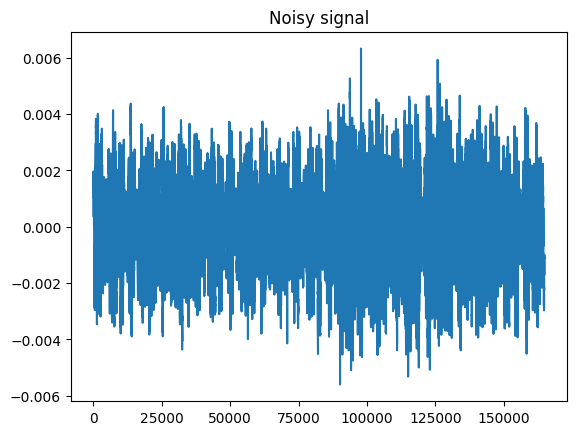

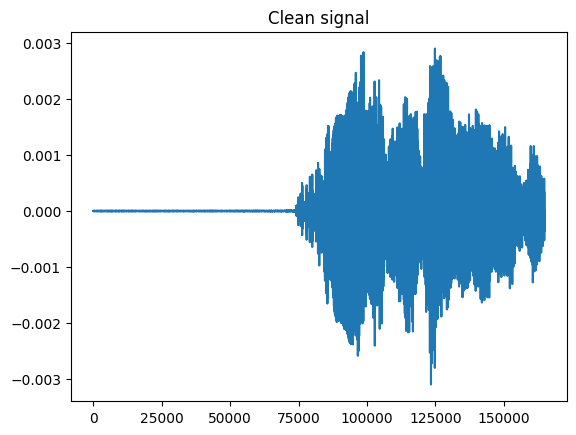

In [ ]:
# ad esempio con i rumori bianchi
model_weights_path = base_dir / "Weights"/ "dc20_model_8.pth"
dcunet20 = DCUnet20(n_fft, hop_length)
optimizer = torch.optim.Adam(dcunet20.parameters())
checkpoint = torch.load(model_weights_path)

dcunet20.load_state_dict(checkpoint)

# caricamento dei dati di test
test_noisy_files = sorted(list(Path(base_dir / 'test' / 'input').rglob('*.wav')))
test_clean_files = sorted(list(Path(base_dir / 'test' / 'target').rglob('*.wav')))

test_dataset = Noise2NoiseDataset(test_noisy_files, test_clean_files, n_fft, hop_length)
test_loader_single_unshuffled = DataLoader(test_dataset, batch_size=1, shuffle=False)

# inferenza su un singolo file, ad esempio quello a indice 5
index = 5
dcunet20.eval()
test_loader_single_unshuffled_iter = iter(test_loader_single_unshuffled)

x_n, x_c = next(test_loader_single_unshuffled_iter)
for _ in range(index):
    x_n, x_c = next(test_loader_single_unshuffled_iter)

# esegue la predizione del modello: prende in input lo spettrogramma del file rumoroso e stima l’audio pulito in dominio temporale (is_istft=True fa la trasformata inversa per tornare al segnale audio)
x_est = dcunet20(x_n, is_istft=True)

# converte il risultato del modello in un array NumPy audio (mono)
x_est_np = x_est[0].view(-1).detach().cpu().numpy()

# Ricostruisci tensore complesso da tensore con ultima dim 2 (reale + immaginario)
x_c_complex = torch.view_as_complex(x_c[0, 0])
x_n_complex = torch.view_as_complex(x_n[0, 0])

# Applica ISTFT e porta a numpy
x_c_np = torch.istft(x_c_complex, n_fft=n_fft, hop_length=hop_length).detach().cpu().numpy()
x_n_np = torch.istft(x_n_complex, n_fft=n_fft, hop_length=hop_length).detach().cpu().numpy()


#valutazione con le metriche
metrics = AudioMetricsGeneral(x_c_np, x_est_np, SAMPLE_RATE)
print(metrics.display())

#visualizzazione della forma d'onda del segnale rumoroso
plt.plot(x_n_np)
plt.title("Noisy signal")
plt.show()

#visualizzazione della forma d'onda del segnale pulito
plt.plot(x_c_np)
plt.title("Clean signal")
plt.show()

# salvataggio del file audio
# se non è normalizzato, potresti volerlo normalizzare per evitare il clipping
x_est_np = x_est_np / np.max(np.abs(x_est_np))  # Normalizza tra -1 e 1 (opzionale, ma consigliato)

# 2. Ridimensiona l'array per avere forma (1, N) → 1 canale, N campioni
x_est_np = np.reshape(x_est_np, (1, -1))

# 3. Converti l'array NumPy in tensor PyTorch
x_est_tensor = torch.from_numpy(x_est_np).float()

# 4. Specifica il percorso di output
output_path = Path(base_dir / "Samples"/"denoised.wav")

# 5. Specifica il sample rate
sample_rate = SAMPLE_RATE  # ad esempio: 16000 o 48000

# 6. Salva l'audio in formato WAV a 16 bit
torchaudio.save(
    str(output_path),
    x_est_tensor,
    sample_rate,
    bits_per_sample=16
)




In [21]:
import os
def overfit_few_batches(net, train_loader, loss_fn, optimizer, num_epochs=50, device='cuda',
                        sample_rate=44100, n_fft=2048, hop_length=512, base_dir="results"):

    net.train()

    # Prendi pochi batch
    few_batches = []
    loader_iter = iter(train_loader)
    for _ in range(2):
        try:
            batch = next(loader_iter)
            few_batches.append(batch)
        except StopIteration:
            break

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        for noisy_x, clean_x in few_batches:
            noisy_x, clean_x = noisy_x.to(device), clean_x.to(device)

            optimizer.zero_grad()
            pred_x = net(noisy_x)
            loss = loss_fn(noisy_x, pred_x, clean_x)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(few_batches)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

    # Post-training: salva audio
    net.eval()
    with torch.no_grad():
        noisy_x, clean_x = few_batches[0]
        noisy_x, clean_x = noisy_x.to(device), clean_x.to(device)

        # Predizione in dominio tempo
        pred_audio = net(noisy_x, is_istft=True)[0].cpu().view(-1).numpy()

        # Reale clean e noisy
        clean_complex = torch.view_as_complex(clean_x[0, 0])
        noisy_complex = torch.view_as_complex(noisy_x[0, 0])
        clean_audio = torch.istft(clean_complex, n_fft=n_fft, hop_length=hop_length).cpu().numpy()
        noisy_audio = torch.istft(noisy_complex, n_fft=n_fft, hop_length=hop_length).cpu().numpy()

        # Normalizzazione
        pred_audio = pred_audio / np.max(np.abs(pred_audio))
        clean_audio = clean_audio / np.max(np.abs(clean_audio))
        noisy_audio = noisy_audio / np.max(np.abs(noisy_audio))

       # Crea la cartella 'Samples' se non esiste
        samples_dir = Path(base_dir) / "Samples"
        samples_dir.mkdir(parents=True, exist_ok=True)

        # Definisci i percorsi dei file
        output_path1 = samples_dir / "final_predicted.wav"
        output_path2 = samples_dir / "final_clean.wav"
        output_path3 = samples_dir / "final_noisy.wav"

        # Salva gli audio
        torchaudio.save(str(output_path1), torch.tensor(pred_audio).unsqueeze(0), sample_rate, bits_per_sample=16)
        torchaudio.save(str(output_path2), torch.tensor(clean_audio).unsqueeze(0), sample_rate, bits_per_sample=16)
        torchaudio.save(str(output_path3), torch.tensor(noisy_audio).unsqueeze(0), sample_rate, bits_per_sample=16)

        try:
          from google.colab import files
          # scarica automaticamente i file su PC locale
          files.download(str(output_path1))
          files.download(str(output_path2))
          files.download(str(output_path3))
        except ImportError:
            print("Non sei su Colab, il download automatico non è supportato qui. I file sono salvati in:", os.path.abspath(samples_dir))

        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(noisy_audio)
        plt.title("Noisy signal")
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.plot(clean_audio)
        plt.title("Clean signal")
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.plot(pred_audio)
        plt.title("Predicted signal")
        plt.show()

# Esempio di utilizzo:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dcunet20.to(device)
optimizer = torch.optim.Adam(dcunet20.parameters())

# Chiama la funzione passando il train_loader, la loss e l’optimizer
overfit_few_batches(dcunet20, train_loader, wsdr_fn, optimizer, num_epochs=50, device=device)


NameError: name 'dcunet20' is not defined

In [ ]:
from pathlib import Path
import torchaudio
import torch

# Definisci base_dir temporaneo per test
samples_dir = Path(base_dir) / "Samples"
samples_dir.mkdir(parents=True, exist_ok=True)

# Percorsi file
output_path1 = samples_dir / "final_predicted.wav"
output_path2 = samples_dir / "final_clean.wav"
output_path3 = samples_dir / "final_noisy.wav"

# Finti dati per test (sostituiscili con i tuoi)
sample_rate = 16000
pred_audio = torch.randn(16000)     # 1 secondo di audio
clean_audio = torch.randn(16000)
noisy_audio = torch.randn(16000)

# Salva
torchaudio.save(str(output_path1), pred_audio.unsqueeze(0), sample_rate, bits_per_sample=16)
torchaudio.save(str(output_path2), clean_audio.unsqueeze(0), sample_rate, bits_per_sample=16)
torchaudio.save(str(output_path3), noisy_audio.unsqueeze(0), sample_rate, bits_per_sample=16)

print("Salvataggio completato.")


Salvataggio completato.
